### **Experimental Setup**
- Python (3.7.8)

### **Install Libraries**

In [116]:
# %pip install pandas
# %pip install featuretools
# %pip install matplotlib
# %pip install scikit-learn
# %pip install autokeras
# %pip install numpy==1.19.5
# %pip install deap update_checker tqdm stopit xgboost
# %pip install tpot

### **Constants**

In [1]:
import warnings
warnings.filterwarnings('ignore')

COMMODITY = 'magnesium'

# File paths
PETROL_FILE_PATH = '../../volza/petroleum/petrol_crude_oil_spot_price.csv'
VOLZA_FILE_PATH = f'../../volza/{COMMODITY}/{COMMODITY}.csv'
PRICE_FILE_PATH = f"../../volza/{COMMODITY}/{COMMODITY}_prices.csv"
AIS_POPULAR_FILE_PATH = '../../ais/ais_ml_features.csv' 

# Columns
PRODUCT_NAME_COLUMN_NAME = 'product-name'
VOLZA_STD_QUANTITY_COLUMN_NAME = 'Std. Quantity'
VOLZA_VALUE_COLUMN_NAME = 'Value'

VOLZA_VALUE_COLUMN = 'Value'  
VOLZA_QUANTITY_COLUMN = 'Std. Quantity (POUND)'
VOLZA_UNIT_RATE_COLUMN = 'Std. Unit Rate ($/POUND)'


WTI_PRODUCT_NAME_LABEL = 'WTI Crude Oil'
BRENT_PRODUCT_NAME_LABEL = 'UK Brent Crude Oil'

SPIKES_THRESHOLD = 2
SPIKES_WINDOW_SIZE = 20

### **Import data**

In [2]:
import pandas
from lib.preprocessing.volza import convert_to_pound  
# Load petrol data and then split into WTI and Brent
petrol_dataframe = pandas.read_csv(PETROL_FILE_PATH, sep=';', index_col='Date', parse_dates=True).sort_values(by='Date')
wti_petrol_dataframe = petrol_dataframe[petrol_dataframe[PRODUCT_NAME_COLUMN_NAME] == WTI_PRODUCT_NAME_LABEL][['Value']].sort_values(by='Date')
brent_petrol_dataframe = petrol_dataframe[petrol_dataframe[PRODUCT_NAME_COLUMN_NAME] == BRENT_PRODUCT_NAME_LABEL][['Value']].sort_values(by='Date')

volza_dataframe = pandas.read_csv(VOLZA_FILE_PATH, index_col='Date', parse_dates=True).sort_values(by='Date')
price_dataframe = pandas.read_csv(PRICE_FILE_PATH, index_col='Date', parse_dates=True).sort_values(by='Date')[['Price']]
ais_popular_dataframe = pandas.read_csv(AIS_POPULAR_FILE_PATH, index_col='Date', parse_dates=True).sort_values(by='Date')[['ship_count', 'popular_port_count']]

if COMMODITY == 'magnesium': price_dataframe['Price'] = price_dataframe['Price'].apply(lambda x: x.replace(',', '')).astype(float)
if COMMODITY == 'magnesium': volza_dataframe.index = pandas.to_datetime(volza_dataframe.index, format='mixed')

volza_dataframe = convert_to_pound(volza_dataframe)[[VOLZA_QUANTITY_COLUMN, VOLZA_UNIT_RATE_COLUMN]]
volza_dataframe = volza_dataframe.resample('D').mean().fillna(method='ffill')

# Remove extraneous values from volza_dataframe as these don't make sense
volza_dataframe = volza_dataframe[volza_dataframe[VOLZA_QUANTITY_COLUMN] < 100000]
volza_dataframe = volza_dataframe[volza_dataframe[VOLZA_UNIT_RATE_COLUMN] < 100000]
volza_dataframe

ModuleNotFoundError: No module named 'lib.preprocessing'

### **Feature Engineering**

In [119]:
from lib.edcr.convert_to_boolean import number_to_boolean, convert_all_numbers_to_boolean
from lib.utils.numeric_range import drange

# ------------------ Convert to boolean ------------------
# Convert values to boolean to make it easier for EDCR
# --------------------------------------------------------
price_dataframe_edcr = convert_all_numbers_to_boolean(price_dataframe, 10)
wti_petrol_dataframe_edcr = convert_all_numbers_to_boolean(wti_petrol_dataframe, 10)
brent_petrol_dataframe_edcr = convert_all_numbers_to_boolean(brent_petrol_dataframe, 10)
volza_dataframe_edcr = convert_all_numbers_to_boolean(volza_dataframe, 100)

price_dataframe_edcr.to_csv(f'edcr/{COMMODITY}_price.csv')
wti_petrol_dataframe_edcr.to_csv(f'edcr/{COMMODITY}_wti_petrol.csv')
brent_petrol_dataframe_edcr.to_csv(f'edcr/{COMMODITY}_brent_petrol.csv')
volza_dataframe_edcr.to_csv(f'edcr/{COMMODITY}_volza.csv')

#### **Add Lagged Features**

### Spike Identification
We use methods for identifying spikes. The ones we currently have availabe are:
- Z-score spike identification with rolling window: Takes the rolling mean of the entire time series and looks for values a certain rolling std.dev above it.

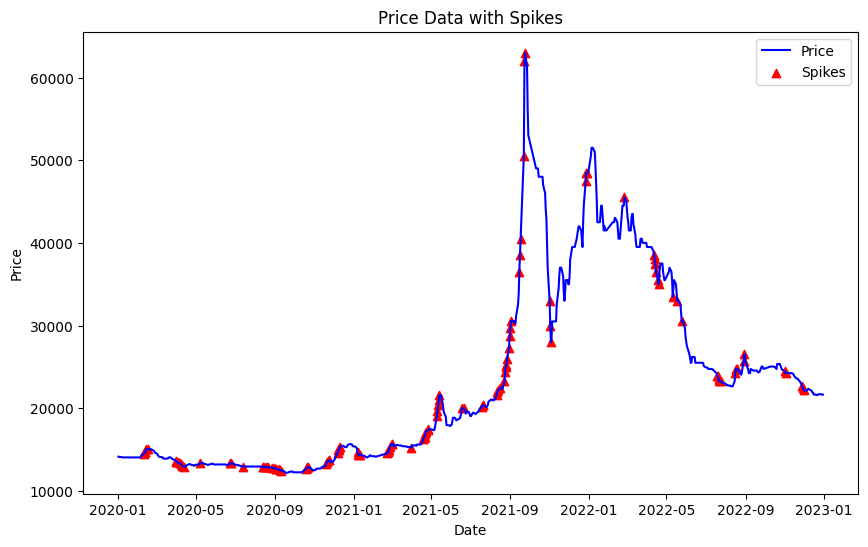

In [120]:
from lib.spike_identification import z_score_spike_detection
import matplotlib.pyplot as plt

price_dataframe['spikes'] = z_score_spike_detection(price_dataframe['Price'], SPIKES_WINDOW_SIZE, SPIKES_THRESHOLD)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(price_dataframe.index, price_dataframe['Price'], label='Price', color='blue')

# Highlighting spikes
spike_indices = price_dataframe[price_dataframe['spikes'] == 1].index
spike_prices = price_dataframe.loc[spike_indices, 'Price']
plt.scatter(spike_indices, spike_prices, color='red', marker='^', label='Spikes')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Data with Spikes')
plt.legend()

# Display the plot
plt.show()

In [121]:
# Join all the dataframes based on date
# Soecify suffix
combined_dataframe = price_dataframe.join(wti_petrol_dataframe.add_prefix('WTI_'), how='outer').join(brent_petrol_dataframe.add_prefix('BRENT_'), how='outer').join(volza_dataframe.add_prefix('VOLZA_'), how='outer').join(ais_popular_dataframe.add_prefix('AIS_'), how='outer')
combined_dataframe = combined_dataframe = combined_dataframe[combined_dataframe['Price'].notna()]
combined_dataframe

,Price,spikes,WTI_Value,BRENT_Value,VOLZA_Std. Quantity (POUND),VOLZA_Std. Unit Rate ($/POUND),AIS_ship_count,AIS_popular_port_count
Date,,,,,,,,
2020-01-02,14150.0,0.0,61.17,67.05,NaN,NaN,NaN,NaN
2020-01-03,14100.0,0.0,63.00,69.08,44168.353568,348.563087,NaN,NaN
2020-01-06,14100.0,0.0,63.27,70.25,5512.652310,658.092958,NaN,NaN
2020-01-07,14100.0,0.0,62.70,68.74,55115.500000,0.936742,NaN,NaN
2020-01-08,14050.0,0.0,59.65,67.31,40124.084000,1.036913,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-12-26,21700.0,0.0,79.57,NaN,NaN,NaN,26482.0,8222.0
2022-12-27,21700.0,0.0,79.45,82.45,55115.500000,1.746332,27245.0,9195.0
2022-12-28,21650.0,0.0,78.89,81.70,NaN,NaN,26021.0,9233.0


In [122]:
import pandas as pd
import numpy as np

def add_lagged_features(df, column, n_lags):
    for i in range(1, n_lags + 1):
      df[f'lag_{i}'] = df[column].shift(i)
    return df

def add_moving_averages(df, column, windows):
    for window in windows:
      df[f'ma_{window}'] = df[column].rolling(window=window).mean()
    return df

def add_returns(df, column):
    df['returns'] = df[column].pct_change()
    return df

def add_volatility(df, column, windows):
    for window in windows:
      df[f'volatility_{window}'] = df[column].rolling(window=window).std()
    return df

combined_dataframe = add_lagged_features(combined_dataframe, 'Price', 5)
combined_dataframe = add_moving_averages(combined_dataframe, 'Price', [5, 10, 20])
combined_dataframe = add_returns(combined_dataframe, 'Price')
combined_dataframe = add_volatility(combined_dataframe, 'Price', [5, 10, 20])

<Axes: xlabel='Date'>

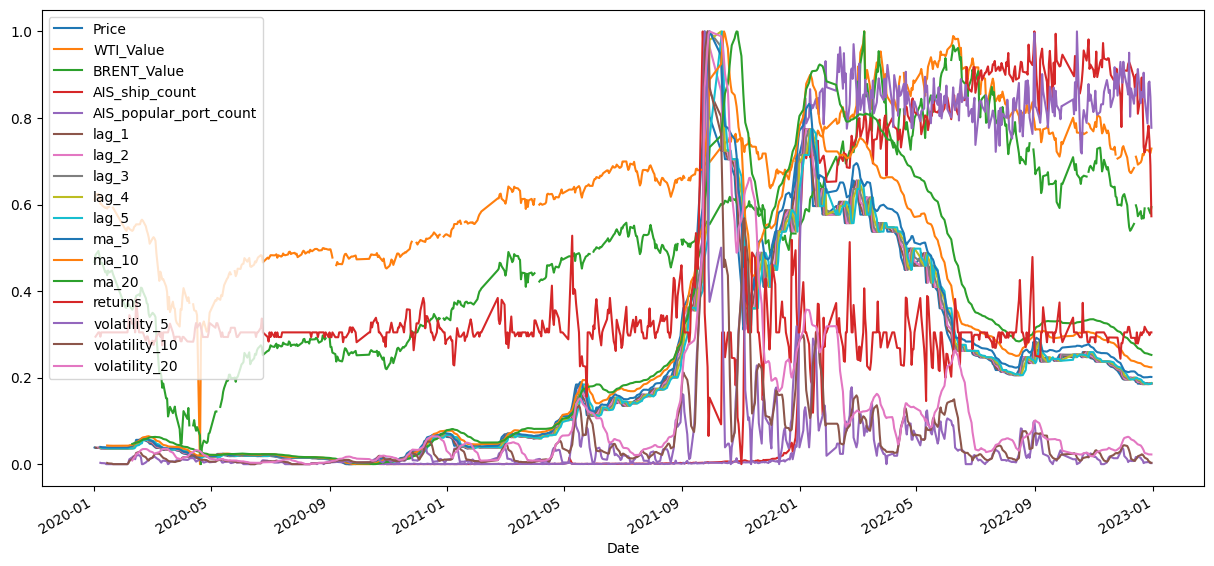

In [123]:
# Graph the combined dataframe where the min and max values are normalized
# Only get dates from 2020 onwards
graph_dataframe = (combined_dataframe - combined_dataframe.min()) / (combined_dataframe.max() - combined_dataframe.min())
graph_dataframe.drop(['spikes', 'VOLZA_Std. Quantity (POUND)', 'VOLZA_Std. Unit Rate ($/POUND)'], axis=1, inplace=True)
graph_dataframe.plot(figsize=(15, 7))

## **Train Test Split**

### **Ensure there is no temporal intermixing in data**

In [124]:
def has_temporal_intermixing(train, test):
    """
    Check if the training and testing sets have temporal intermixing
    """
    return train.index.max() > test.index.min() 

### **Models** 

In [125]:
import autokeras
from sklearn.metrics import classification_report

In [126]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import kerastuner
import autokeras as ak

def eval_score(y_true, y_pred):
    return f1_score(y_true, y_pred)
# for sampler in [RandomUnderSampler(), RandomOverSampler(), None]:
# Shuffle is set to False to ensure that the data is split in a way that the training data comes before the testing data
X = combined_dataframe.drop('spikes', axis=1)
y = combined_dataframe['spikes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)
X_train_new, y_train_new = RandomUnderSampler().fit_resample(X_train, y_train)

# Initialize the structured data classifier
clf = autokeras.StructuredDataClassifier(
  max_trials=100, 
  overwrite=True,
)
clf.fit(X_train_new, y_train_new, epochs=100)
pred = clf.predict(X_test)
display(pandas.DataFrame(classification_report(y_test, pred, output_dict=True)))

In [129]:
from tpot import TPOTClassifier

X = combined_dataframe.drop('spikes', axis=1)
y = combined_dataframe['spikes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)
X_train, y_train = RandomUnderSampler().fit_resample(X_train, y_train)

# Initialize the structured data classifier
clf = TPOTClassifier(
  generations=5, population_size=20, cv=5,
  random_state=42, verbosity=2, scoring='f1'
)
clf.fit(X_train, y_train_new, epochs=100)
pred = clf.predict(X_test)
display(pandas.DataFrame(classification_report(y_test, pred, output_dict=True)))

NameError: name '_C' is not defined